In [1]:
from IPython.display import clear_output
!pip install opensimplex
clear_output()

In [5]:
!pip install noise
clear_output()

In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from tqdm import tqdm
from opensimplex import OpenSimplex
from skimage.filters import threshold_otsu

from scipy.ndimage import zoom
from noise import snoise2

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


np.random.seed(42)

cpu


In [46]:
class XIT2Dataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256), noise_type=None):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.noise_type = noise_type
        self.image_paths = self._load_image_paths()
    
    def _load_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return sorted(image_paths)
    
    def __len__(self):
        return len(self.image_paths)

    def set_noise_type(self, noise_type):
        self.noise_type = noise_type
    
    def _add_noise(self, image):
        if self.noise_type == "simplex":
            frequency = 2 ** -6  # Starting frequency
            octaves = 6          # Number of octaves
            persistence = 0.8    # Decay rate
            lacunarity = 2.0     # Lacunarity
            diffusion_steps = 87
            noise = np.zeros_like(image)
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    noise[i, j] = snoise2(i * frequency, # The first two inputs
                                          j * frequency, # may tuggle or not.
                                          octaves=octaves, 
                                          persistence=persistence, 
                                          lacunarity=lacunarity)
            # Normalize the noise map to [0, 1]
            noise = (noise - noise.min()) / (noise.max() - noise.min())
            # Forward diffusion process (87 steps)
            for step in range(diffusion_steps):
                image = image + noise * (1 / diffusion_steps)
                image = np.clip(image, 0.0, 1.0)  # Ensure pixel values remain in [0, 1]
            # for _ in range(diffusion_steps):
            #     noise = np.clip(noise + np.random.normal(0, 0.01, noise.shape), 0, 1)
            # image = np.clip(image + noise, 0, 1)
        
        if self.noise_type == "coarse":
            coarse_resolution = (16, 16) # Generate low-resolution noise
            noise = np.random.normal(loc=0, scale=0.2, size=coarse_resolution)
            upsampled_noise = zoom(noise, (self.target_size[0] / coarse_resolution[0], 
                                           self.target_size[1] / coarse_resolution[1]))
            image = np.clip(image + upsampled_noise, 0, 1)

        return image
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Load as grayscale
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        image = np.array(image, dtype=np.float32) / 255.0
        if self.noise_type:
            image = self._add_noise(image)
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))  # Scale back to [0, 255]
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)        
        # Expand to (C, H, W) format (channel dimension)
        image = image.unsqueeze(0) if not self.transform else image
        label = 0  # Label is always 0 (healthy)
        return image, label

    def plot_samples(self, idx, num_samples=8, label_title='Healthy'):
        if num_samples % 4 != 0:
            raise ValueError("Number of samples must be a multiple of 4.")
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 10))
        for i in range(num_samples):
            # idx = np.random.randint(len(self.image_paths))
            image, label = self[idx]
            image_np = image.squeeze(0).numpy()
            axes[i].imshow(image_np, cmap='gray')
            axes[i].set_title(f"Label: {label_title}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

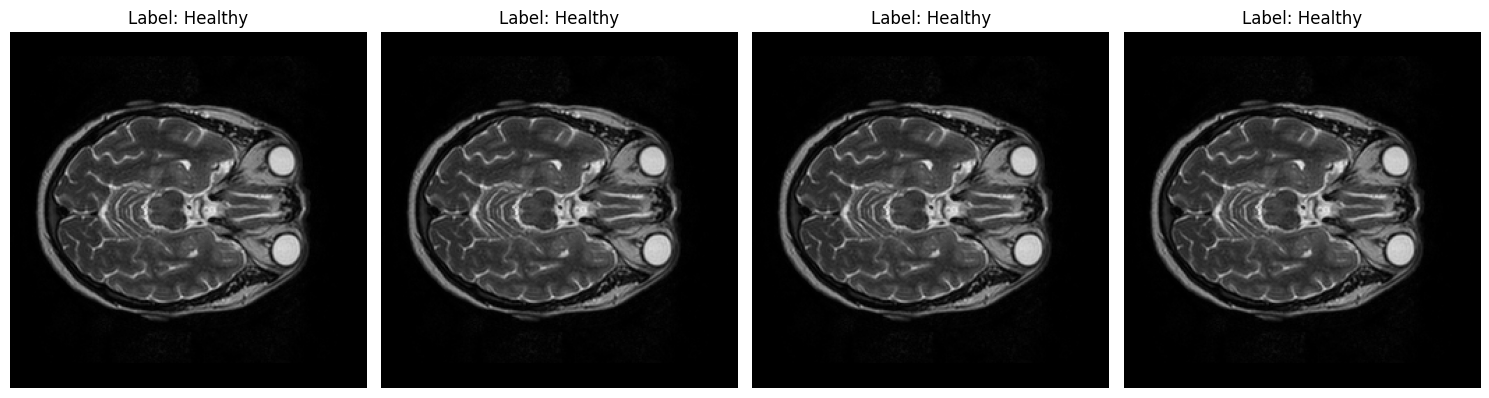

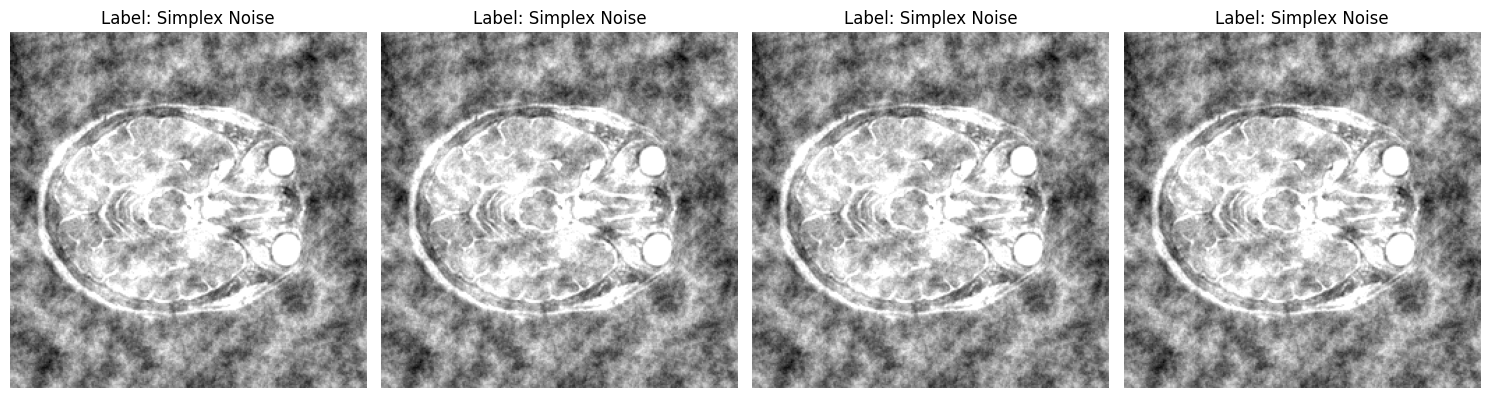

In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

ixit1 = XIT2Dataset("/kaggle/input/ixit2-slices", transform)
idx = np.random.randint(len(ixit1.image_paths))
ixit1.plot_samples(idx, 4, label_title='Healthy')
ixit1.set_noise_type("simplex")
ixit1.plot_samples(idx, 4, label_title='Simplex Noise')

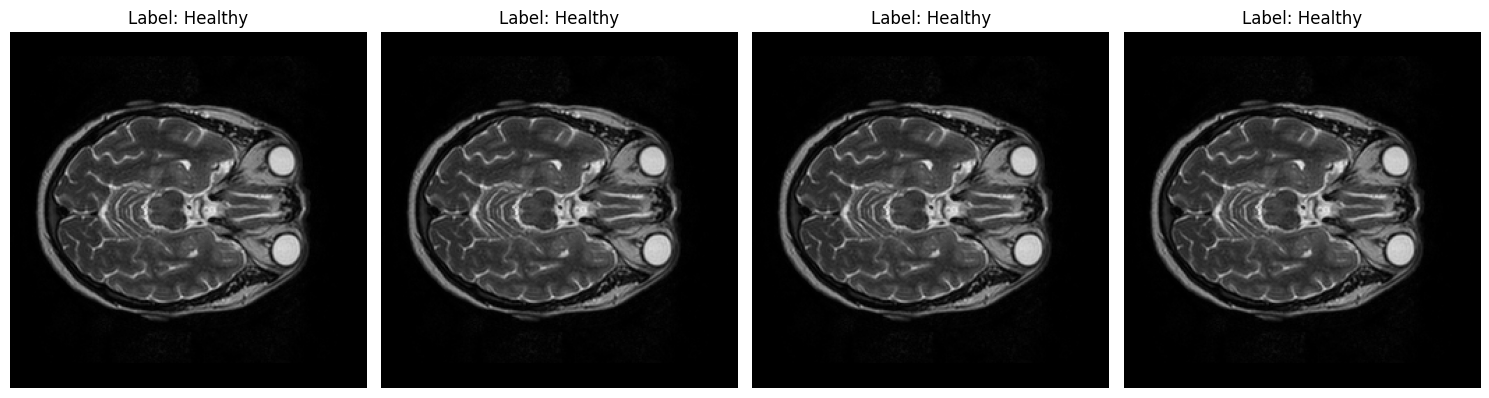

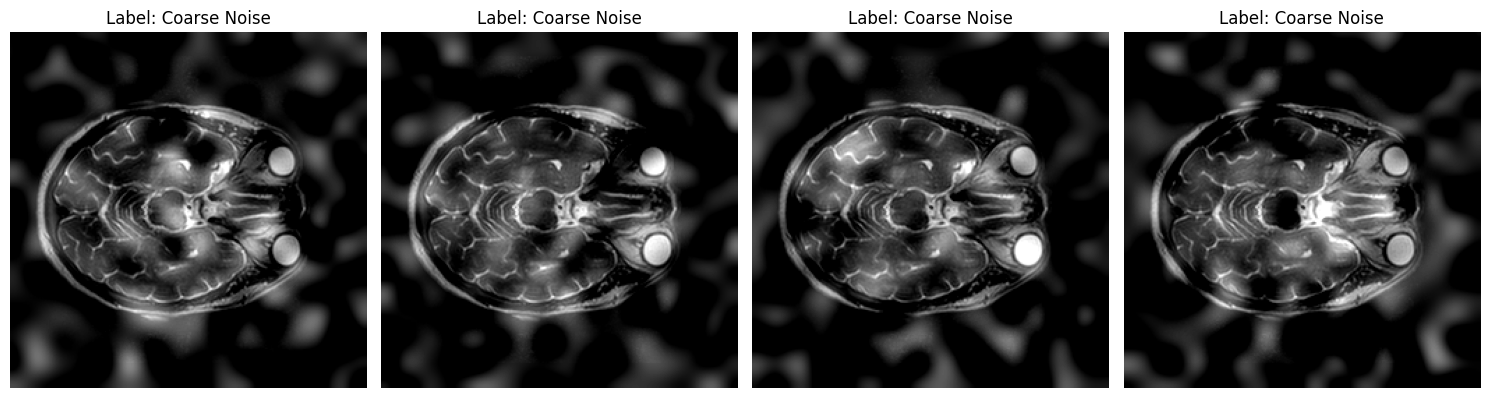

In [48]:
ixit2 = XIT2Dataset("/kaggle/input/ixit2-slices", transform)
ixit2.plot_samples(idx, 4, label_title='Healthy')
ixit2.set_noise_type("coarse")
ixit2.plot_samples(idx, 4, label_title='Coarse Noise')

In [5]:
class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.image_paths, self.mask_paths = self._load_paths()
    
    def _load_paths(self):
        image_paths = []
        mask_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith("_t2.nii"):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root, file.replace("_t2.nii", "_seg.nii")))
        return sorted(image_paths), sorted(mask_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
        
        # Extract the middle slice along the z-axis
        z_index = image.shape[-1] // 2
        image = image[:, :, z_index]  # Extract 2D slice
        mask = mask[:, :, z_index]   # Extract 2D slice
    
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = resize(image, self.target_size, order=1, mode='reflect', anti_aliasing=True)
        mask = resize(mask, self.target_size, order=0, mode='reflect', anti_aliasing=False)
    
        # Convert NumPy arrays back to PIL images for transformation
        image = Image.fromarray((image * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))
    
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else: # Convert to tensors
            image = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0)  # Add channel dim
            mask = torch.tensor(np.array(mask), dtype=torch.float32)
    
        return image, mask

    def plot_samples(self, num_samples=4):
        if num_samples % 2 != 0:
            raise ValueError("Number of samples must be even.")        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, mask = self[idx]
            image_np = image.squeeze(0).numpy() if isinstance(image, torch.Tensor) else image
            mask_np = mask.squeeze(0).numpy() if len(mask.shape) == 3 else mask
            axes[0, i].imshow(image_np, cmap='gray')
            axes[0, i].set_title("T2 Image")
            axes[0, i].axis('off')
            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title("Segmentation Mask")
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.show()

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

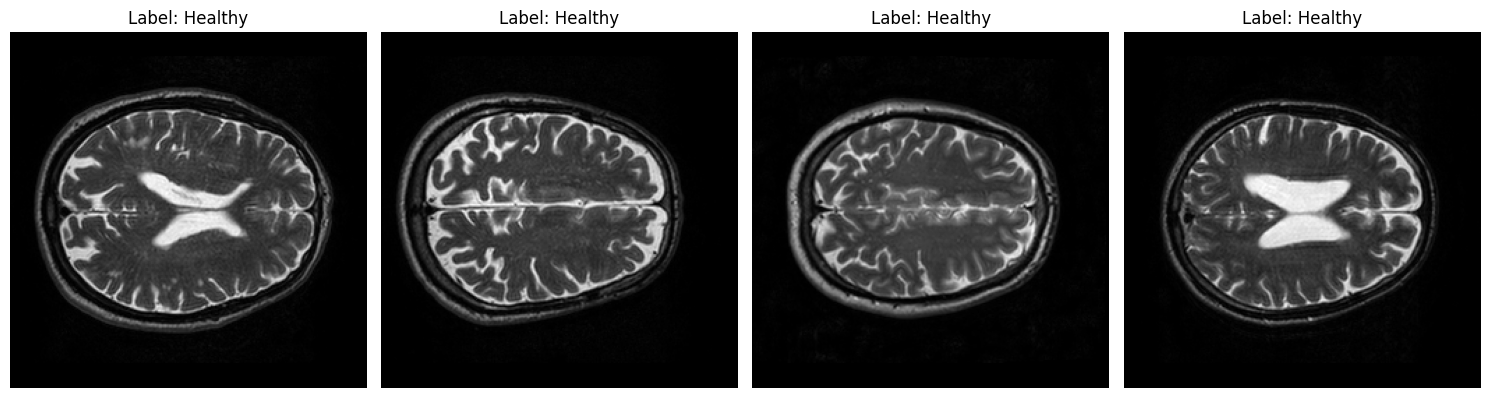

In [7]:
ixit = XIT2Dataset("/kaggle/input/ixit2-slices", transform)
ixit.plot_samples(4)

In [8]:
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset(data_dir=data_dir, transform=transform)

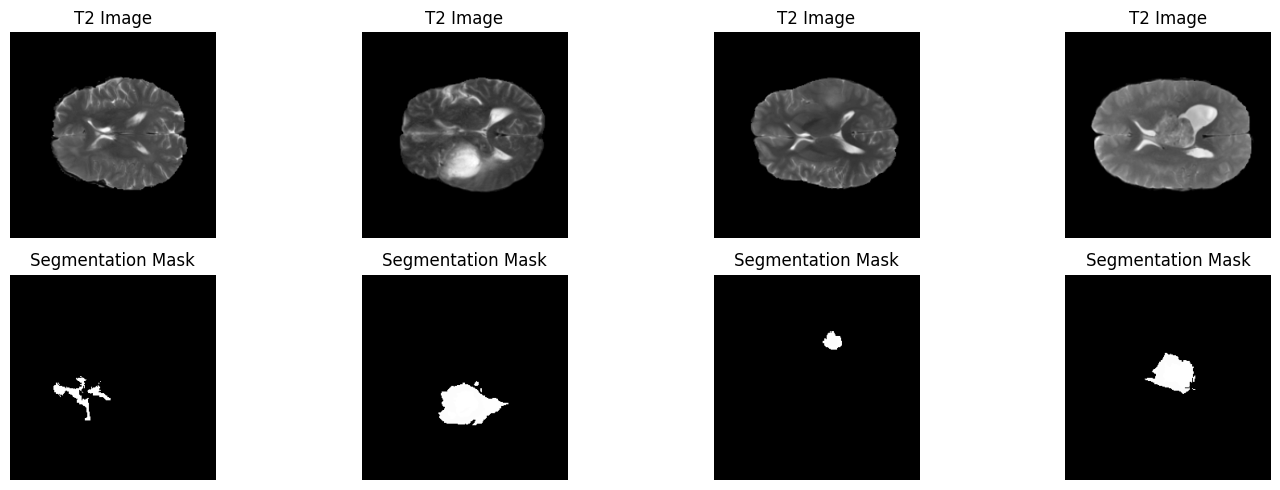

In [9]:
dataset.plot_samples()

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 16 * 16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 16, 16)
        x = self.deconv(x)
        return x

In [11]:
class TriVAE(nn.Module):
    def __init__(self, latent_dim):
        super(TriVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [12]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.L1Loss()(recon_x, x)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

def triplet_loss(anchor, positive, negative, margin=1.0):
    dist_pos = torch.norm(anchor - positive, p=2, dim=1)
    dist_neg = torch.norm(anchor - negative, p=2, dim=1)
    return torch.mean(torch.relu(dist_pos - dist_neg + margin))

In [13]:
def apply_noise(noise_type, images):
    if noise_type == 'coarse':
        # Generate coarse noise directly in PyTorch
        noise = torch.randn((images.size(0), 1, 32, 32), device=device) * 0.2  # Low-res Gaussian noise
        noise = torch.nn.functional.interpolate(noise, size=images.shape[2:], mode='bilinear', align_corners=False)
        return images + noise
    elif noise_type == 'simplex':
        # Generate simplex noise directly in PyTorch
        simplex = OpenSimplex(seed=42)
        scale = 1.0 / 64.0
        noise = torch.zeros_like(images, device=device)
        for i in range(images.size(2)):  # Height
            for j in range(images.size(3)):  # Width
                noise[:, :, i, j] = torch.tensor([simplex.noise2(i * scale, j * scale) for _ in range(images.size(0))], device=device)
        return images + noise
    else:
        return images.clone()  # No noise

In [14]:
def train(model, dataloader, optimizer, dataset, noise_type='coarse', epochs=10):
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        print(f"Epoch {epoch + 1}/{epochs}")
        for images, _ in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}"):
            images = images.to(device)
            # Generate anchor, positive, and negative samples
            anchor = images
            positive = images.clone()
            # Add noise to negative samples explicitly
            negative = apply_noise(noise_type, images) 
            optimizer.zero_grad()
            # Forward pass for each sample
            recon_anchor, mu_anchor, logvar_anchor = model(anchor)
            recon_positive, mu_positive, logvar_positive = model(positive)
            recon_negative, mu_negative, logvar_negative = model(negative)
            # Compute losses
            vae_loss_anchor = vae_loss(recon_anchor, anchor, mu_anchor, logvar_anchor)
            vae_loss_positive = vae_loss(recon_positive, positive, mu_positive, logvar_positive)
            vae_loss_negative = vae_loss(recon_negative, negative, mu_negative, logvar_negative)
            t_loss = triplet_loss(mu_anchor, mu_positive, mu_negative)
            # Combine losses
            loss = vae_loss_anchor + vae_loss_positive + vae_loss_negative + t_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {total_loss / len(dataloader):.4f}")
    torch.save(model.state_dict(), 'model_final.pth') 
    print("Model saved!")

def evaluate(model, dataloader):
    model.eval()
    residual_maps = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            recon_images, _, _ = model(images)
            residual_map = torch.abs(images - recon_images).cpu().numpy()
            residual_maps.append(residual_map)
    return np.concatenate(residual_maps)

In [15]:
train_loader = DataLoader(ixit, batch_size=128, shuffle=True)

In [16]:
latent_dim = 512
model = TriVAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
train(model, train_loader, optimizer, ixit, noise_type='coarse', epochs=20)

Epoch 1/20


Training Epoch 1: 100%|██████████| 226/226 [05:12<00:00,  1.38s/it]


Epoch [1/20] - Loss: 7.6597
Epoch 2/20


Training Epoch 2: 100%|██████████| 226/226 [03:24<00:00,  1.10it/s]


Epoch [2/20] - Loss: 1.3866
Epoch 3/20


Training Epoch 3: 100%|██████████| 226/226 [03:23<00:00,  1.11it/s]


Epoch [3/20] - Loss: 1.3754
Epoch 4/20


Training Epoch 4: 100%|██████████| 226/226 [03:21<00:00,  1.12it/s]


Epoch [4/20] - Loss: 1.3734
Epoch 5/20


Training Epoch 5: 100%|██████████| 226/226 [03:21<00:00,  1.12it/s]


Epoch [5/20] - Loss: 1.3713
Epoch 6/20


Training Epoch 6: 100%|██████████| 226/226 [03:25<00:00,  1.10it/s]


Epoch [6/20] - Loss: 1.3704
Epoch 7/20


Training Epoch 7: 100%|██████████| 226/226 [03:22<00:00,  1.12it/s]


Epoch [7/20] - Loss: 1.3696
Epoch 8/20


Training Epoch 8: 100%|██████████| 226/226 [03:22<00:00,  1.12it/s]


Epoch [8/20] - Loss: 1.3691
Epoch 9/20


Training Epoch 9: 100%|██████████| 226/226 [03:23<00:00,  1.11it/s]


Epoch [9/20] - Loss: 1.3687
Epoch 10/20


Training Epoch 10: 100%|██████████| 226/226 [03:22<00:00,  1.12it/s]


Epoch [10/20] - Loss: 1.3683
Epoch 11/20


Training Epoch 11: 100%|██████████| 226/226 [03:22<00:00,  1.12it/s]


Epoch [11/20] - Loss: 1.3681
Epoch 12/20


Training Epoch 12: 100%|██████████| 226/226 [03:22<00:00,  1.12it/s]


Epoch [12/20] - Loss: 1.3679
Epoch 13/20


Training Epoch 13: 100%|██████████| 226/226 [03:23<00:00,  1.11it/s]


Epoch [13/20] - Loss: 1.3677
Epoch 14/20


Training Epoch 14: 100%|██████████| 226/226 [03:23<00:00,  1.11it/s]


Epoch [14/20] - Loss: 1.3677
Epoch 15/20


Training Epoch 15: 100%|██████████| 226/226 [03:22<00:00,  1.11it/s]


Epoch [15/20] - Loss: 1.3675
Epoch 16/20


Training Epoch 16: 100%|██████████| 226/226 [03:22<00:00,  1.12it/s]


Epoch [16/20] - Loss: 1.3675
Epoch 17/20


Training Epoch 17: 100%|██████████| 226/226 [03:24<00:00,  1.11it/s]


Epoch [17/20] - Loss: 1.3671
Epoch 18/20


Training Epoch 18: 100%|██████████| 226/226 [03:20<00:00,  1.13it/s]


Epoch [18/20] - Loss: 1.3670
Epoch 19/20


Training Epoch 19: 100%|██████████| 226/226 [03:19<00:00,  1.13it/s]


Epoch [19/20] - Loss: 1.3669
Epoch 20/20


Training Epoch 20: 100%|██████████| 226/226 [03:20<00:00,  1.12it/s]


Epoch [20/20] - Loss: 1.3670
Model saved!


In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu

# def evaluate_and_visualize(model, dataset, device, num_samples=4):
#     """
#     Evaluate the model on BraTS slices, compute Dice score, and visualize results.
    
#     Args:
#         model (nn.Module): Trained Tri-VAE model.
#         dataset (Dataset): BraTSDataset instance.
#         device (torch.device): Device to run the model on (CPU or GPU).
#         num_samples (int): Number of slices to evaluate and visualize.
#     """
#     model.to(device)
#     model.eval()

#     fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
#     dice_scores = []

#     with torch.no_grad():
#         for i in range(num_samples):
#             # Randomly select a tumor slice
#             idx = np.random.randint(len(dataset))
#             image, mask = dataset[idx]
#             image = image.to(device).unsqueeze(0)  # Add batch dimension

#             # Forward pass through the model
#             recon_image, _, _ = model(image)
#             residual_map = torch.abs(image - recon_image).squeeze(0).cpu().numpy()

#             # Threshold residual map to identify tumor region
#             threshold = threshold_otsu(residual_map)
#             predicted_mask = (residual_map > threshold).astype(np.uint8)

#             # Compute Dice score
#             ground_truth = mask.numpy().astype(np.uint8)
#             intersection = np.sum(predicted_mask * ground_truth)
#             dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth) + 1e-6)
#             dice_scores.append(dice)

#             # Visualize results
#             axes[i, 0].imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
#             axes[i, 0].set_title("Input Slice")
#             axes[i, 0].axis('off')

#             axes[i, 1].imshow(recon_image.squeeze(0).cpu().numpy(), cmap='gray')
#             axes[i, 1].set_title("Reconstructed Slice")
#             axes[i, 1].axis('off')

#             axes[i, 2].imshow(residual_map, cmap='hot')
#             axes[i, 2].set_title("Residual Map")
#             axes[i, 2].axis('off')

#             axes[i, 3].imshow(ground_truth, cmap='gray', alpha=0.5, label='Ground Truth')
#             axes[i, 3].imshow(predicted_mask, cmap='jet', alpha=0.5, label='Predicted Mask')
#             axes[i, 3].set_title(f"Tumor Prediction (Dice: {dice:.4f})")
#             axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

#     print(f"Average Dice Score: {np.mean(dice_scores):.4f}")

In [ ]:
# brats_dataset = BraTSDataset(
#     data_dir=data_dir,
#     transform=transforms.Compose([transforms.ToTensor()]),
#     target_size=(256, 256)
# )

# # Evaluate and visualize
# evaluate_and_visualize(model, brats_dataset, device, num_samples=4)

In [ ]:
def evaluate_brats(model, dataset, num_patients=100, threshold=0.1, num_samples_to_display=5):
    """ Evaluate the trained Tri-VAE model on BraTS tumor slices and compute Dice scores """
    model.to(device)
    model.eval()
    
    dice_scores = []
    samples_to_display = []    
    with torch.no_grad():
        for idx in range(min(num_patients, len(dataset))):
            image, mask = dataset[idx]
            image = image.to(device).unsqueeze(0)  # Add batch dimension
            # Forward pass through the model
            recon_image, _, _ = model(image)
            residual_map = torch.abs(image - recon_image).squeeze(0).cpu().numpy()            
            # Threshold residual map to identify tumor region
            predicted_mask = (residual_map > threshold).astype(np.uint8)
            
            ground_truth = mask.numpy().astype(np.uint8)
            intersection = np.sum(predicted_mask * ground_truth)
            dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth) + 1e-6)
            dice_scores.append(dice)
            if len(samples_to_display) < num_samples_to_display:
                samples_to_display.append((image.squeeze(0).cpu().numpy(), residual_map, predicted_mask, ground_truth))
    
    visualize_results(samples_to_display, dice_scores[:num_samples_to_display])
    return np.mean(dice_scores)

def visualize_results(samples, dice_scores):
    """ Visualize input slices, residual maps, predicted masks, and ground truth masks """
    num_samples = len(samples)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    for i, (input_slice, residual_map, predicted_mask, ground_truth) in enumerate(samples):
        input_slice = input_slice.squeeze()
        residual_map = residual_map.squeeze()
        predicted_mask = predicted_mask.squeeze()
        ground_truth = ground_truth.squeeze()
        axes[i, 0].imshow(input_slice, cmap='gray')
        axes[i, 0].set_title("Input Slice")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(residual_map, cmap='hot')
        axes[i, 1].set_title("Residual Map")
        axes[i, 1].axis('off')
        axes[i, 2].imshow(predicted_mask, cmap='gray', alpha=1)
        axes[i, 2].set_title(f"Predicted Mask (Dice: {dice_scores[i]:.4f})")
        axes[i, 2].axis('off')
        axes[i, 3].imshow(ground_truth, cmap='gray', alpha=1)
        axes[i, 3].set_title("Ground Truth Mask")
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
brats_dataset = BraTSDataset(
    data_dir=data_dir,
    transform=transforms.Compose([transforms.ToTensor()]),
    target_size=(256, 256)
)
average_dice = evaluate_brats(model, brats_dataset, num_patients=100, threshold=0.1, num_samples_to_display=10)
print(f"Average Dice Score: {average_dice:.4f}")